In [1]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.modeling.models import BlackBody

from scipy import stats
from scipy.stats import binned_statistic
from iminuit import Minuit

from dust_extinction.parameter_averages import G23

# File loading and postprocessing (Binning + de-extinction)

In [2]:
# Load file
file = fits.open('../coadded_1dspec.fits')
print(file.info())

Filename: ../coadded_1dspec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      51   ()      
  1  SPECTRUM      1 BinTableHDU     33   3403R x 5C   [1D, 1D, 1D, 1D, 1K]   
None


In [3]:
data = file[1].data
print(data.columns)

ColDefs(
    name = 'wave'; format = '1D'
    name = 'wave_grid_mid'; format = '1D'
    name = 'flux'; format = '1D'
    name = 'ivar'; format = '1D'
    name = 'mask'; format = '1K'
)


In [4]:
wave = data.wave
flux = data.flux
noise = 1./np.sqrt(data.ivar)

In [5]:
#binfactor=10
#fluxbin = flux[:(flux.size // binfactor) * binfactor].reshape(-1, binfactor).mean(axis=1)
#wavebin = wave[:(wave.size // binfactor) * binfactor].reshape(-1, binfactor).mean(axis=1)
#noisebin = noise[:(noise.size // binfactor) * binfactor].reshape(-1, binfactor).mean(axis=1) / np.sqrt(binfactor)

# (Almost) raw plot of data - With binning

In [6]:
### Weighed average method is used for binning:

binfactor=4
subarray_flux = flux[:(flux.size // binfactor) * binfactor].reshape(-1, binfactor)
subarray_noise = noise[:(noise.size // binfactor) * binfactor].reshape(-1, binfactor)
wavebin = wave[:(wave.size // binfactor) * binfactor].reshape(-1, binfactor).mean(axis=1)

fluxbin = np.average(subarray_flux, weights=1/(subarray_noise)**2, axis=1)
noisebin = np.sqrt(1/((1/subarray_noise**2).sum(axis=1)))

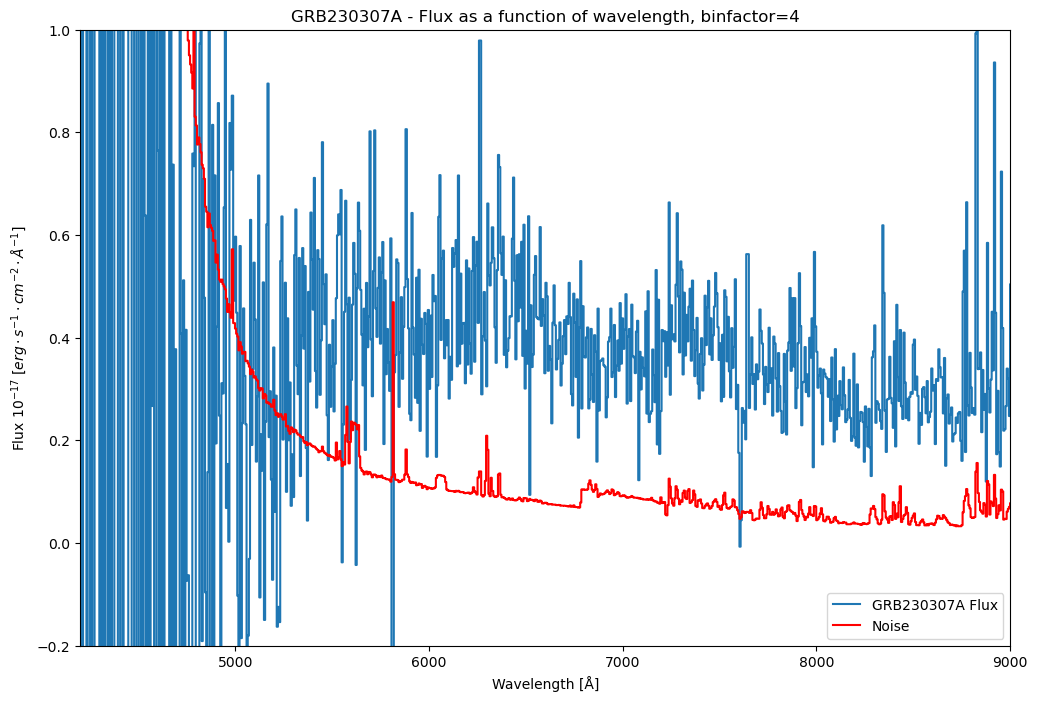

In [7]:
fig = plt.figure()
fig.set_size_inches(12, 8)
#plt.step(wave,flux)
#plt.step(wave,noise,color='red')
plt.title("GRB230307A - Flux as a function of wavelength, binfactor={}".format(binfactor))
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux $10^{-17}$ [$erg \cdot s^{-1} \cdot cm^{-2} \cdot Å^{-1}$]") #Arbitrary units
plt.step(wavebin,fluxbin, label="GRB230307A Flux")
plt.step(wavebin,noisebin,color='red', label="Noise")
plt.xlim(4200,9000.)
plt.ylim(-0.2,1.)
plt.legend()
plt.show()

# Power-law function

In [8]:
def function(x, a, k): #Power-law function to curve fit to
    return a*x**k

# Binning

In [9]:
# Mean binning
#def binner(flux, wave, noise, binfactor):
    #fluxbin = flux[:(flux.size // binfactor) * binfactor].reshape(-1, binfactor).mean(axis=1)
    #wavebin = wave[:(wave.size // binfactor) * binfactor].reshape(-1, binfactor).mean(axis=1)
    #noisebin = noise[:(noise.size // binfactor) * binfactor].reshape(-1, binfactor).mean(axis=1) / np.sqrt(binfactor)
    #return fluxbin, wavebin, noisebin

In [10]:
#def binner(flux, wave, noise, binfactor):
    #fluxbin = binned_statistic(flux, statistic="count", bins=binfactor)
    #wavebin = binned_statistic(wave, statistic="count", bins=binfactor)
    #noisebin = binned_statistic(noise, statistic="count", bins=binfactor)
    #return fluxbin, wavebin, noisebin
    
### Weighed average binner

def binner(flux, wave, noise, binfactor):
    subarray_flux = flux[:(flux.size // binfactor) * binfactor].reshape(-1, binfactor)
    subarray_noise = noise[:(noise.size // binfactor) * binfactor].reshape(-1, binfactor)
    wavebin = wave[:(wave.size // binfactor) * binfactor].reshape(-1, binfactor).mean(axis=1)

    fluxbin = np.average(subarray_flux, weights=1/(subarray_noise)**2, axis=1)
    noisebin = np.sqrt(1/((1/subarray_noise**2).sum(axis=1)))
    return fluxbin, wavebin, noisebin

# Fit-functions

In [11]:
def curve_fit_func(wavebin, fluxbin, noisebin, cutoff_min, cutoff_max):
    
    def chi2_owncalc(a, k):
        y_fit = function(wavebin, a, k)
        chi2 = np.sum(((fluxbin - y_fit) / noisebin)**2)
        return chi2

    minuit_chi2 = Minuit(chi2_owncalc, a=0, k=0)
    minuit_chi2.errordef = 1.0
    minuit_chi2.migrad()
    
    fit_a, fit_k = minuit_chi2.values[:]
    Chisq = minuit_chi2.fval
    Ndof = len(fluxbin) - minuit_chi2.nfit
    
    xdata = np.linspace(cutoff_min, cutoff_max, 1000)
    ydata = function(xdata, fit_a, fit_k)
    fluxbin_model = function(wavebin, fit_a, fit_k)
    red_Chisq = Chisq/Ndof
    Prob_value = stats.chi2.sf(red_Chisq, 1)
    
    #Calculate residuals!
    residuals = fluxbin - function(wavebin, fit_a, fit_k)
    return xdata, ydata, minuit_chi2.values[:], minuit_chi2.errors[:], Chisq, residuals, Ndof, Prob_value

# Alternative Chi^2 calculation method (unused)

Another way to calculate the minimum chi^2. Not really used in the code, but the method is provided here...
Also it probably has to be modified, it might not work with the current code.

In [12]:
def chi_sq_func(wavebin, fluxbin, noisebin, a_guess_values, k_guess_values, cutoff_max):
    '''Function that calculates the a and k constant of the power-law function from minimum chi^2'''
    xdata = np.linspace(4200, cutoff_max, 1000)
    
    chi2_surface = np.zeros((len(a_guess_values),len(k_guess_values)))
    
    for i,a_try in enumerate(a_guess_values):
        for j,k_try in enumerate(k_guess_values):
            y_mod_try          = function(wavebin, a_try, k_try)
            chi2_surface[j,i]  = np.sum((fluxbin - y_mod_try)**2/noisebin**2)
        
    a_lowest_chi = np.where(chi2_surface == np.min(chi2_surface))[1][0]
    k_lowest_chi = np.where(chi2_surface == np.min(chi2_surface))[0][0]
    
    a = a_guess_values[a_lowest_chi]
    k = k_guess_values[k_lowest_chi]
    
    ydata = function(xdata, a, k)
    
    ### Calculating likelihood ###
    likelihood = np.exp(-chi2_surface/2.) 
    likelihood /= np.sum(likelihood)
    
    prob_a  = np.sum(likelihood, axis=0)
    prob_a /= np.trapz(prob_a, a_guess_values)

    prob_k  = np.sum(likelihood, axis=1)
    prob_k /= np.trapz(prob_k, k_guess_values)
    
    ### Final values + Errors of 1 standard deviation! ###
    best_a = np.trapz(prob_a*a_guess_values, a_guess_values)
    sigma_a = np.sqrt(np.trapz(prob_a*(a_guess_values-best_a)**2, a_guess_values))
    
    best_k = np.trapz(prob_k*k_guess_values, k_guess_values)
    sigma_k = np.sqrt(np.trapz(prob_k*(k_guess_values-best_k)**2, k_guess_values))
    
    Errors = [sigma_a, sigma_k]
    Chisq = np.min(chi2_surface)
    par = [best_a, best_k]
    
    #Calculate residuals!
    residuals = fluxbin - function(wavebin, a, k)
    return xdata, ydata, par, Errors, Chisq, residuals, chi2_surface

# Plotting function

In [13]:
#### PLOTTING FUNCTION TO PLOT ALL RESULTS! ######
def Plotting_func(flux, wave, noise, a_guess_values=0, k_guess_values=0, binning=False, binfactor=1, 
                  save=False, chi_sq_method = False, cutoff_min=4200, cutoff_max=9000., unextinguish=True):## Plot results!
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    chi2_surface = 0
    
    if binning==False and binfactor==1:
        wavebin = wave
        fluxbin = flux
        noisebin = noise
        
        ax1.step(wavebin,fluxbin, label="GRB230307A Flux", color="blue")
        ax1.step(wavebin,noisebin,color='green', label="Noise")
        
        if unextinguish==True:
            #Model is defined for dereddening
            ext = G23(Rv=3.1)
            
            ##A_v=0.5R_v
            
            #We now deredden (Av data for GRB230307A reddening provided)!
            fluxbin /= ext.extinguish(wavebin*u.AA, Av=0.239)
            
        
        if chi_sq_method == False:
            xdata, ydata, par, Errors, Chisq, residuals, Ndof, Prob_value = curve_fit_func(wavebin, fluxbin, noisebin, cutoff_min, cutoff_max)
            t1 = ax1.text(6800, 0.92, '$A = ({} \pm {}) \cdot 10^2$'.format(round(par[0]/1e2, 1), round(Errors[0]/1e2, 1)), fontsize="xx-large", color="white")
            t1.set_bbox(dict(facecolor='gray', alpha=0.5, edgecolor='gray'))
            t2 = ax1.text(6800, 0.85, '$\lambda = {} \pm {}$'.format(round(par[1], 3), round(Errors[1], 3)), fontsize="xx-large", color="white")
            t2.set_bbox(dict(facecolor='gray', alpha=0.5, edgecolor='gray'))
            t3 = ax1.text(6800, 0.78, '$P(\chi^2={}, Ndof = {}) = {}$'.format(int(Chisq), Ndof, round(Prob_value, 3)), fontsize="xx-large", color="white")
            t3.set_bbox(dict(facecolor='gray', alpha=0.5, edgecolor='gray'))
        elif chi_sq_method == True:
            xdata, ydata, par, Errors, Chisq, residuals, chi2_surface = chi_sq_func(wavebin, fluxbin, noisebin, a_guess_values, k_guess_values, cutoff_max)
            Chisq = Chisq/(len(fluxbin)-len(par))
            ax1.text(5100, 0.95, '$\chi^2_{red}$ = ' + "{}".format(round(Chisq, 4)), fontsize="xx-large", color="red")
        if unextinguish==False:
            ax1.set_title("GRB230307A - Flux as a func of wavelength, {}Å to {}Å, raw data".format(cutoff_min, cutoff_max))
        elif unextinguish==True:
            ax1.set_title("GRB230307A - Flux as a func of wavelength, {}Å to {}Å, raw data - dereddened".format(cutoff_min, cutoff_max))
        
    elif binning==True and binfactor!=1:
        fluxbin, wavebin, noisebin = binner(flux, wave, noise, binfactor)
        
        ax1.step(wavebin,fluxbin, label="GRB230307A Flux", color="blue")
        ax1.step(wavebin,noisebin,color='green', label="Noise")
        
        if unextinguish==True:
            ext = G23(Rv=3.1)
            fluxbin /= ext.extinguish(wavebin*u.AA, Av=0.239)
        
        if chi_sq_method == False:
            xdata, ydata, par, Errors, Chisq, residuals, Ndof, Prob_value = curve_fit_func(wavebin, fluxbin, noisebin, cutoff_min, cutoff_max)
            t1 = ax1.text(6800, 0.92, '$A = ({} \pm {}) \cdot 10^2$'.format(round(par[0]/1e2, 1), round(Errors[0]/1e2, 1)), fontsize="xx-large", color="white")
            t1.set_bbox(dict(facecolor='gray', alpha=0.5, edgecolor='gray'))
            t2 = ax1.text(6800, 0.85, '$\lambda = {} \pm {}$'.format(round(par[1], 3), round(Errors[1], 3)), fontsize="xx-large", color="white")
            t2.set_bbox(dict(facecolor='gray', alpha=0.5, edgecolor='gray'))
            t3 = ax1.text(6800, 0.78, '$P(\chi^2={}, Ndof = {}) = {}$'.format(int(Chisq), Ndof, round(Prob_value, 3)), fontsize="xx-large", color="white")
            t3.set_bbox(dict(facecolor='gray', alpha=0.5, edgecolor='gray'))
        elif chi_sq_method == True:
            xdata, ydata, par, Errors, Chisq, residuals, chi2_surface = chi_sq_func(wavebin, fluxbin, noisebin, a_guess_values, k_guess_values, cutoff_max)
            Chisq = Chisq/(len(fluxbin)-len(par))
            ax1.text(5100, 0.95, '$\chi^2_{red}$ = ' + "{}".format(round(Chisq, 4)), fontsize="xx-large", color="red")
        
        if unextinguish==False:
            ax1.set_title("GRB230307A - Flux as a func of wavelength, {}Å to {}Å, binfactor={}".format(cutoff_min, cutoff_max, binfactor))
        elif unextinguish==True:
            ax1.set_title("GRB230307A - Flux as a func of wavelength, {}Å to {}Å, binfactor={} - dereddened".format(cutoff_min, cutoff_max, binfactor))
            
    ax1.set_ylabel("Flux $10^{-17}$ [$erg \cdot s^{-1} \cdot cm^{-2} \cdot Å^{-1}$]") 
    ax1.plot(xdata, ydata, "--", color="red", label="Power-law fit")
    ax1.set_xlim(cutoff_min,cutoff_max)
    ax1.set_ylim(-0.2,1.)
    ax1.legend(loc="lower right")
    ax1.grid()

    ax2.set_xlabel("Wavelength [Å]")
    ax2.set_ylabel("Residuals [A.U.]")
    ax2.plot(wavebin, residuals, ".", color="black", alpha=0.5, label="Residuals")
    ax2.plot(xdata, np.zeros(1000), "-.", color="orange", label="Best-fit model line")
    ax2.legend(loc="lower right")
    ax2.set_ylim(-1, 1.)
    ax2.grid()

    fig.set_size_inches(12, 10)
    plt.tight_layout()
    if save==True and binning==False:
        plt.savefig("Power-law-graph-raw-data_{}Å-to-{}Å.png".format(cutoff_min, cutoff_max), dpi=200)
    elif save==True and binning==True:
        plt.savefig("Power-law-graph-bins={}_{}Å-to-{}Å.png".format(binfactor, cutoff_min, cutoff_max), dpi=200)
    plt.show()
    
    return chi2_surface, par, Chisq

# Results for 9200Å>lambda>4200Å - No binning

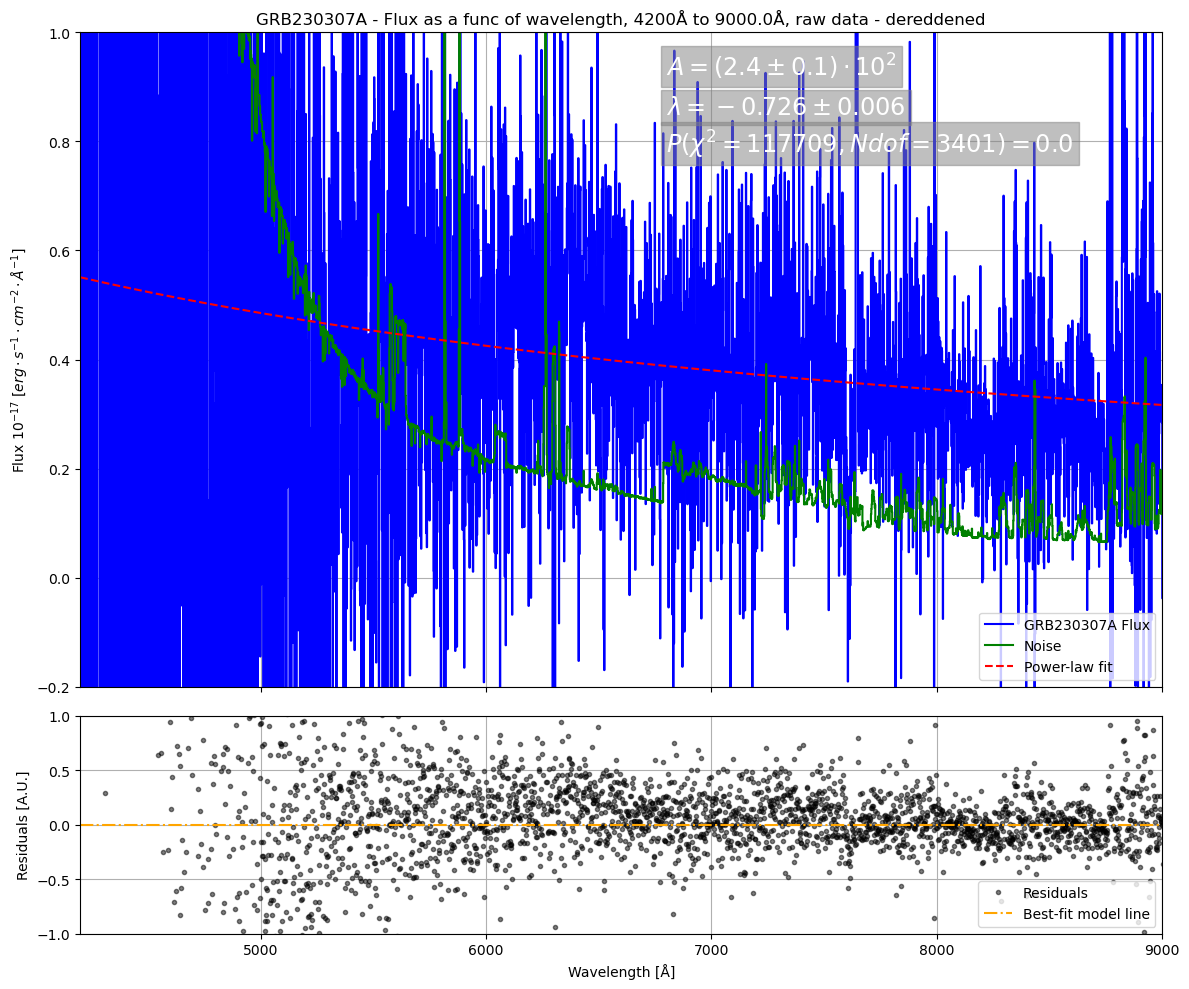

(0, [236.19447997522815, -0.7264871607908161], 117709.98579473917)

In [14]:
Plotting_func(flux, wave, noise, save=False)

# Results for 9200Å>lambda>4200Å - binfactor = 2

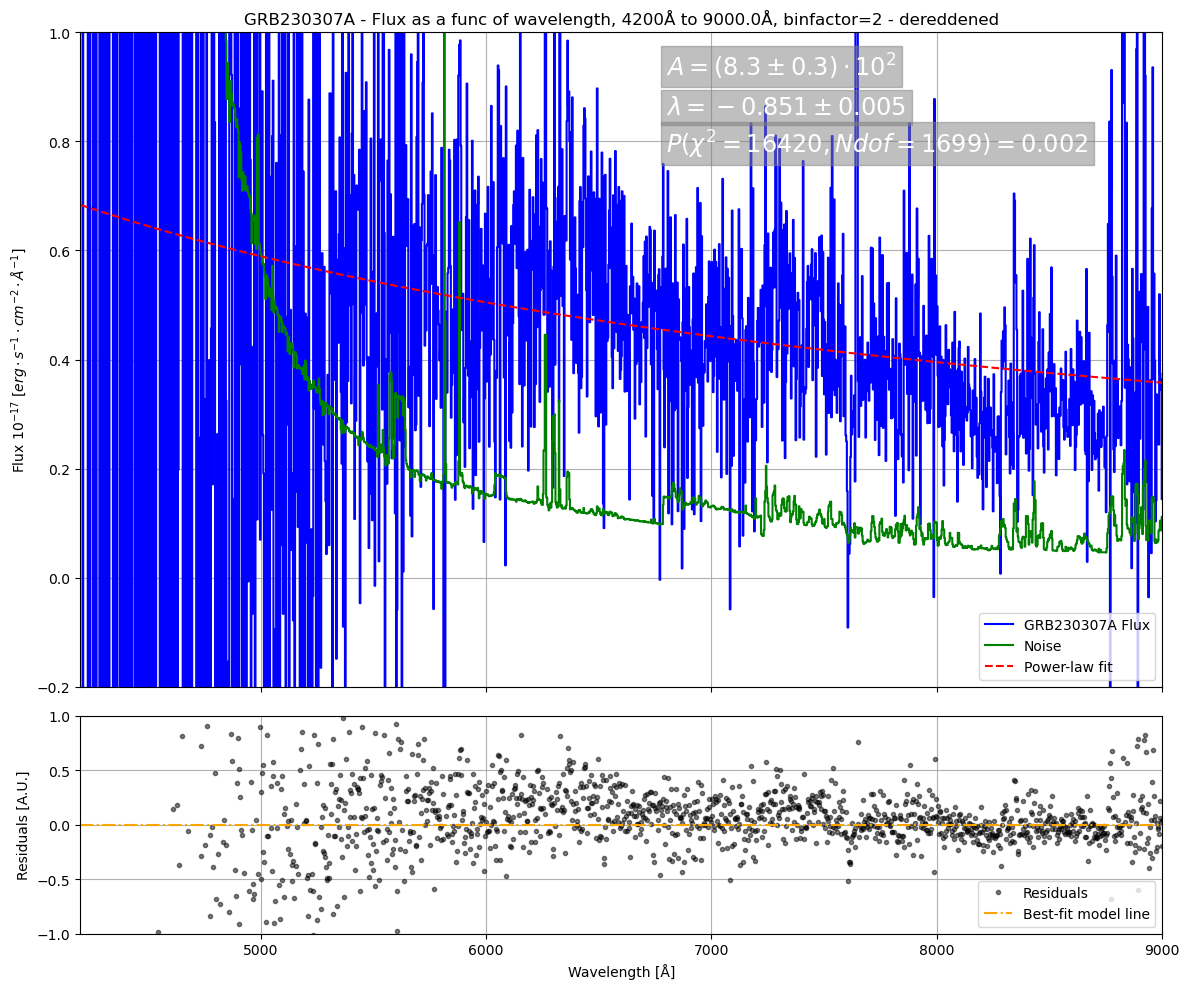

(0, [827.3737366070887, -0.850856961856949], 16420.136077177227)

In [15]:
Plotting_func(flux, wave, noise, binning=True, save=False, binfactor=2)

# Results for 9200Å>lambda>4200Å - binfactor=3

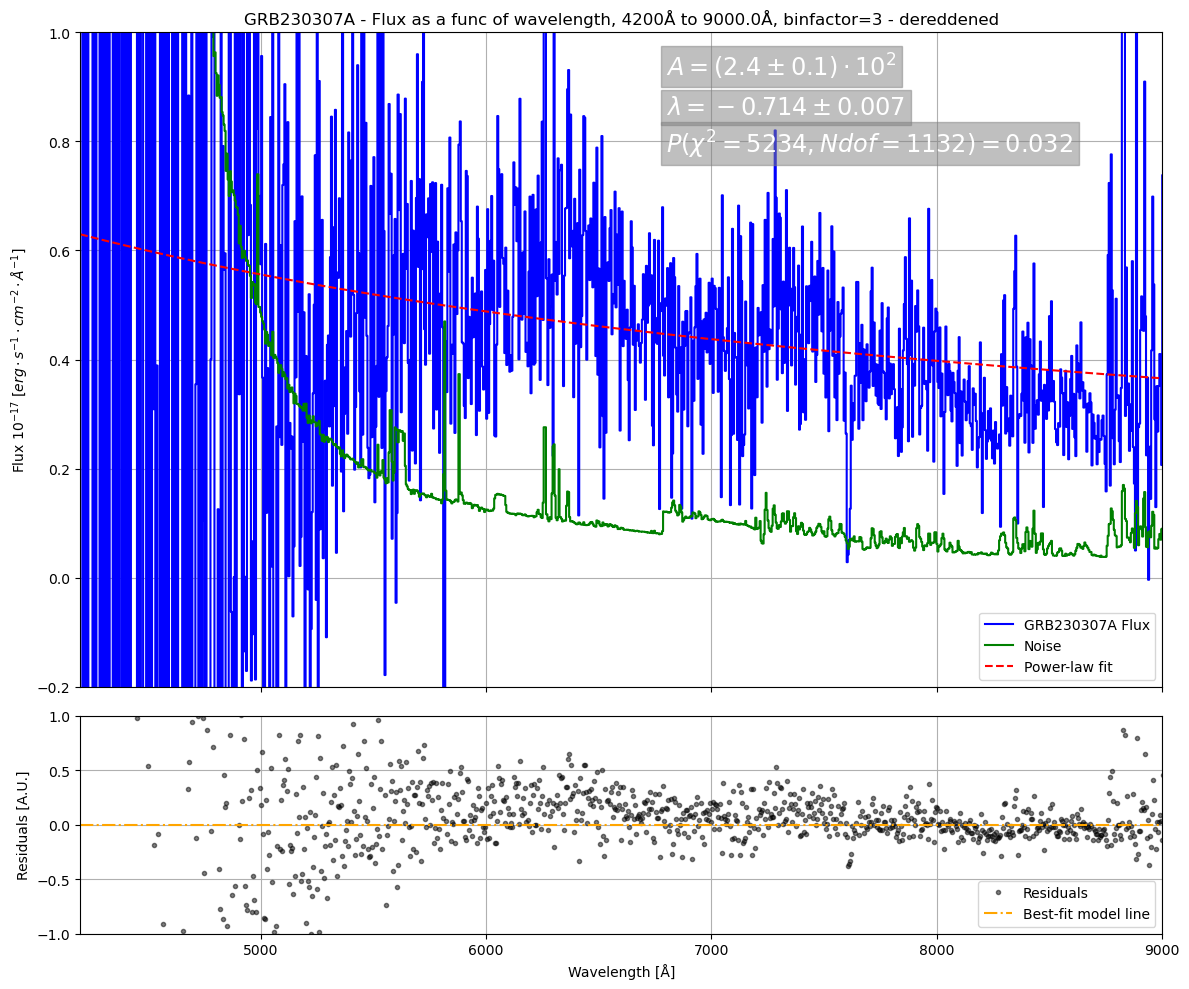

(0, [242.71600267434144, -0.7137236113310506], 5234.169748889354)

In [16]:
Plotting_func(flux, wave, noise, binfactor=3, binning=True, save=False)

# Results for 9200Å>lambda>4200Å - binfactor = 4

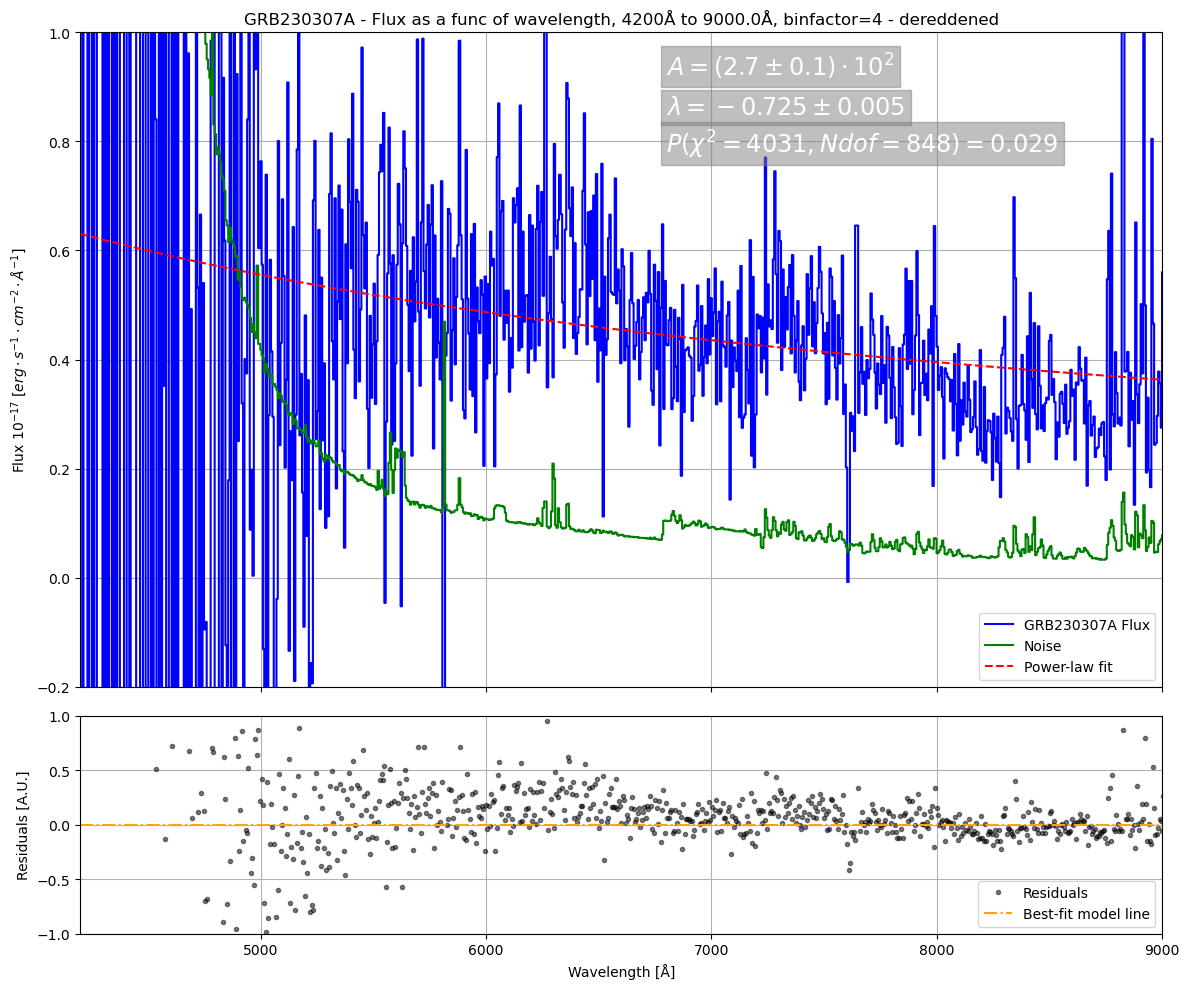

(0, [266.704059529475, -0.7248822193879484], 4031.3547664058497)

In [17]:
Plotting_func(flux, wave, noise, binfactor=4, binning=True, save=False, unextinguish=True)

# Results for 9200Å>lambda>4200Å - binfactor = 5

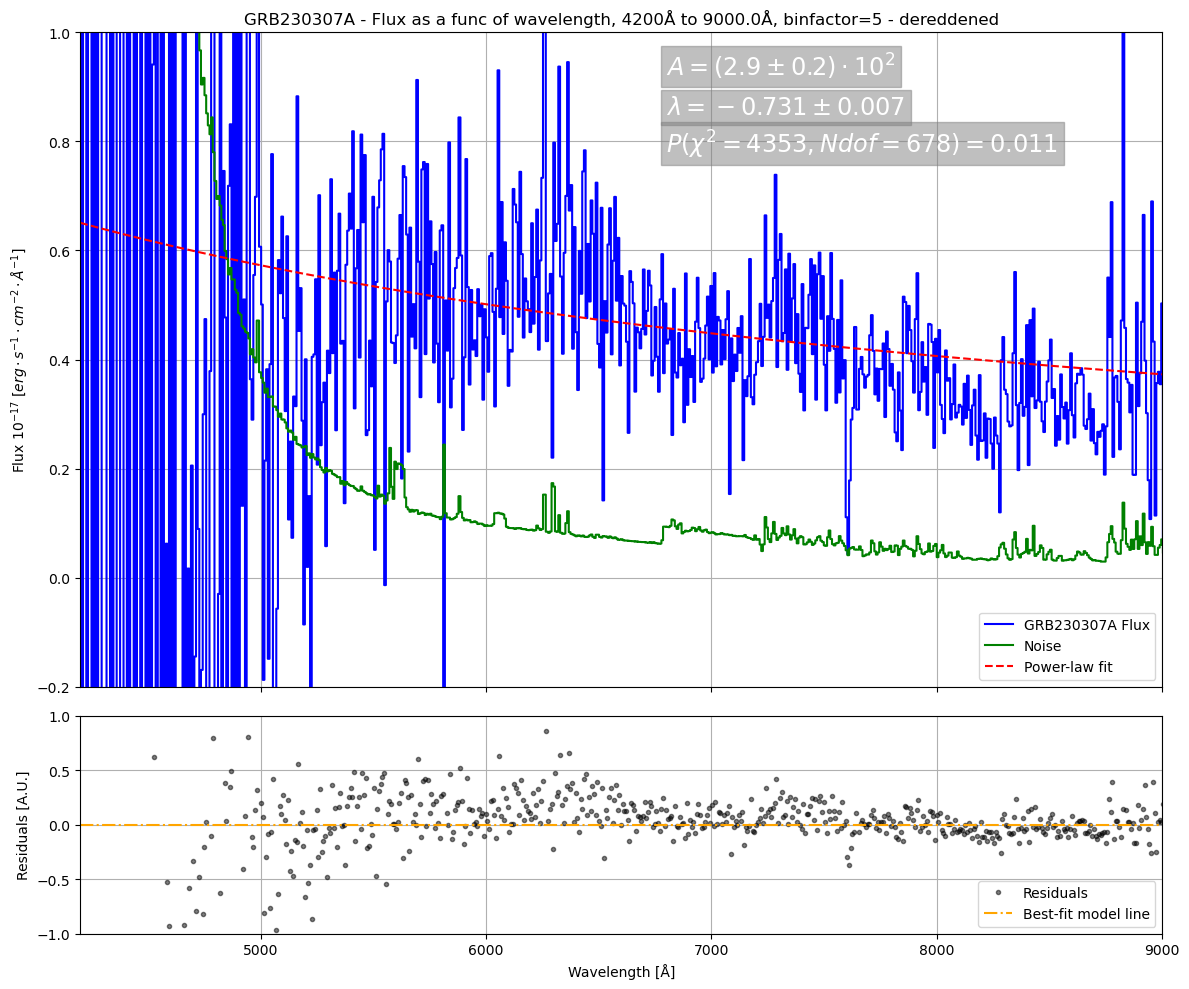

(0, [289.0710380511993, -0.7307335209691777], 4353.809971848295)

In [18]:
Plotting_func(flux, wave, noise, binfactor=5, binning=True, save=False)

# Results for 9200Å>lambda>4200Å - binfactor 6

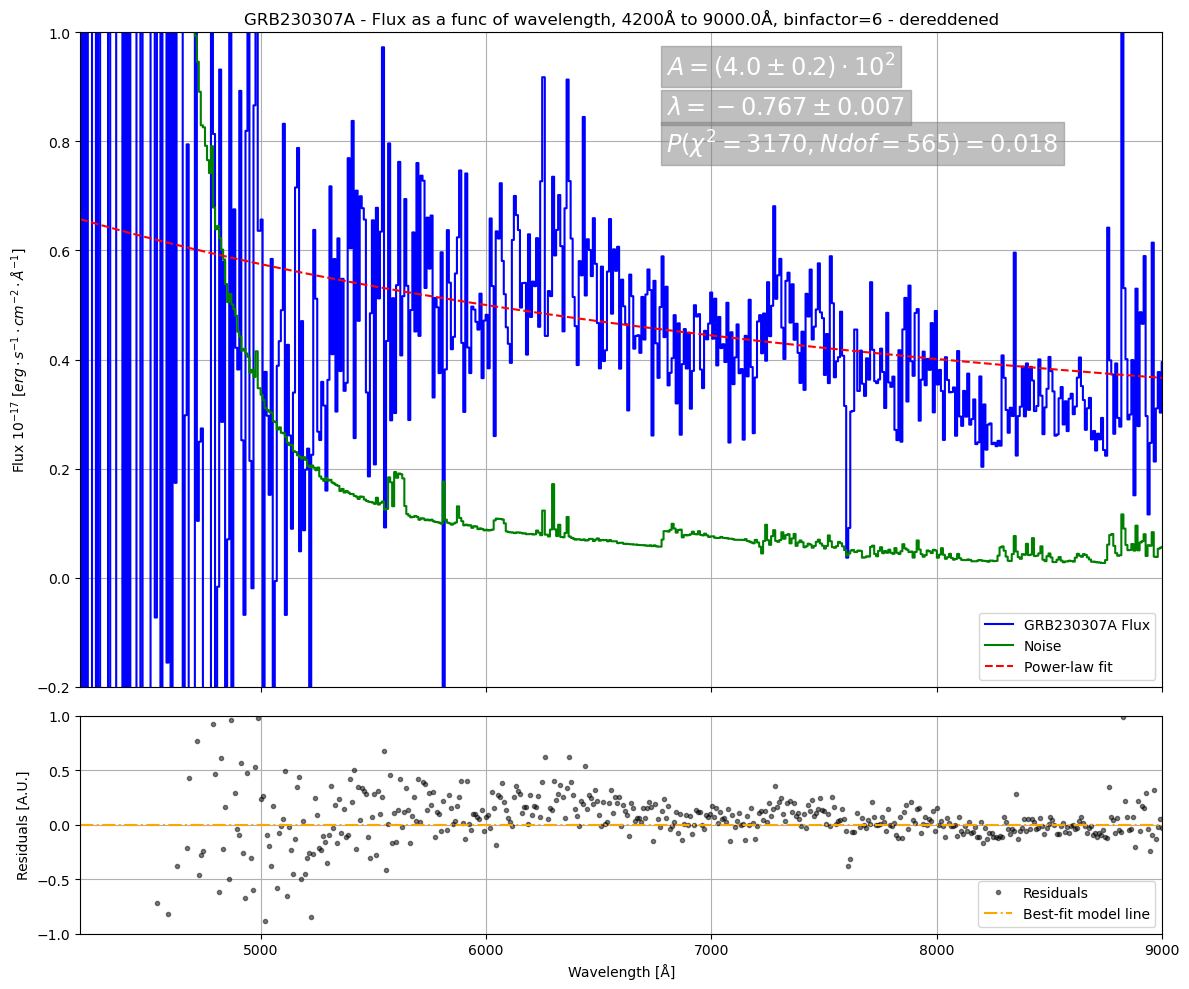

(0, [396.5432395506396, -0.7674042713015362], 3170.234369933229)

In [19]:
Plotting_func(flux, wave, noise, binfactor=6, binning=True, save=False)

# Results for 9200Å>lambda>4200Å - binfactor 7

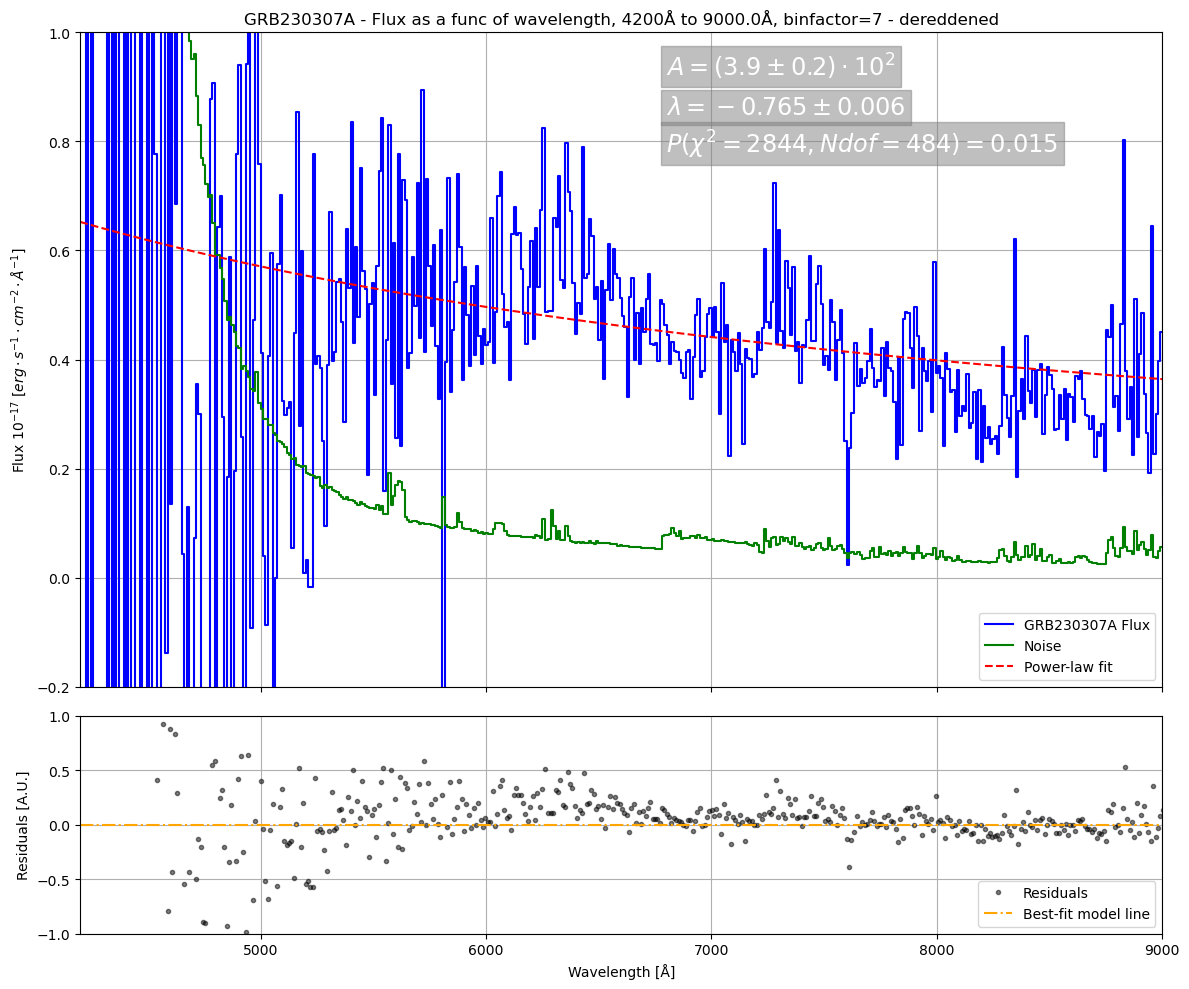

(0, [386.8824527379923, -0.7653718117086165], 2844.437477209418)

In [20]:
Plotting_func(flux, wave, noise, binfactor=7, binning=True, save=False)

# Results for 9200Å>lambda>4200Å - binfactor 10

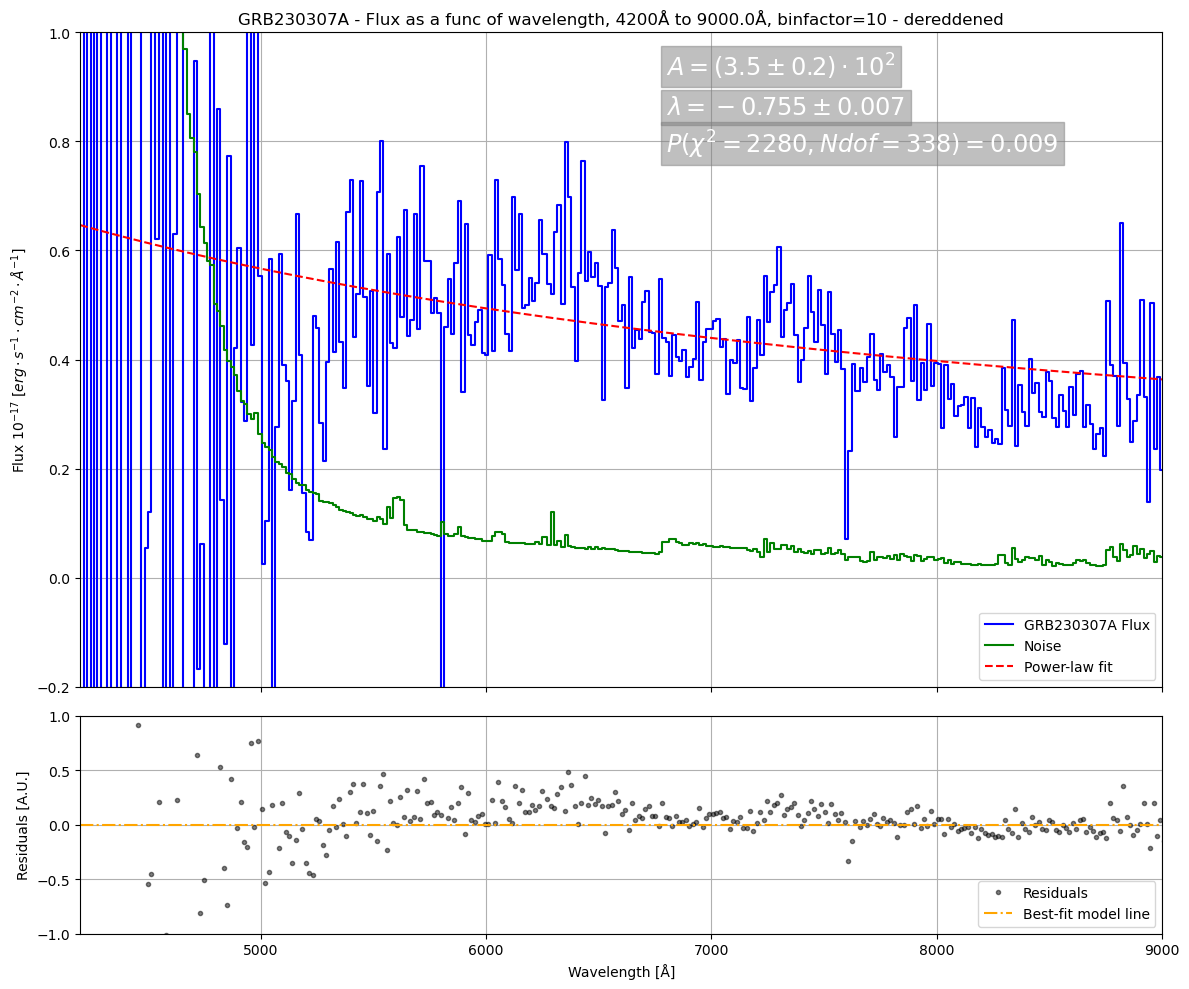

(0, [353.0153263602502, -0.7554625140234251], 2280.2227985734266)

In [21]:
Plotting_func(flux, wave, noise, binfactor=10, binning=True, save=False)

# Results for 9200Å>lambda>4200Å - binfactor = 20

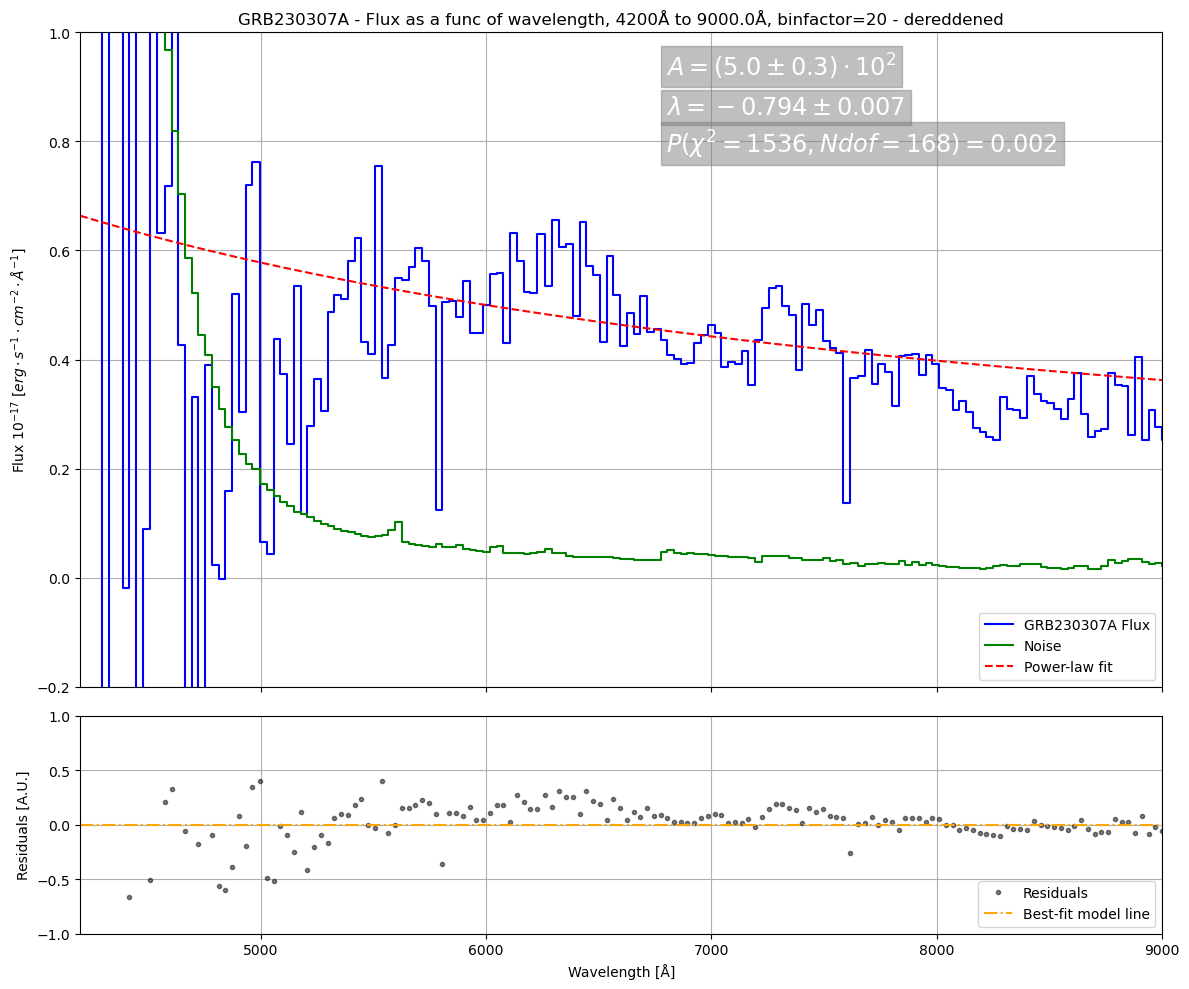

(0, [500.8512502173291, -0.7942481330791556], 1536.9617071793896)

In [22]:
Plotting_func(flux, wave, noise, binfactor=20, binning=True, save=False)

# Results for 9200Å>lambda>4200Å - binfactor 25

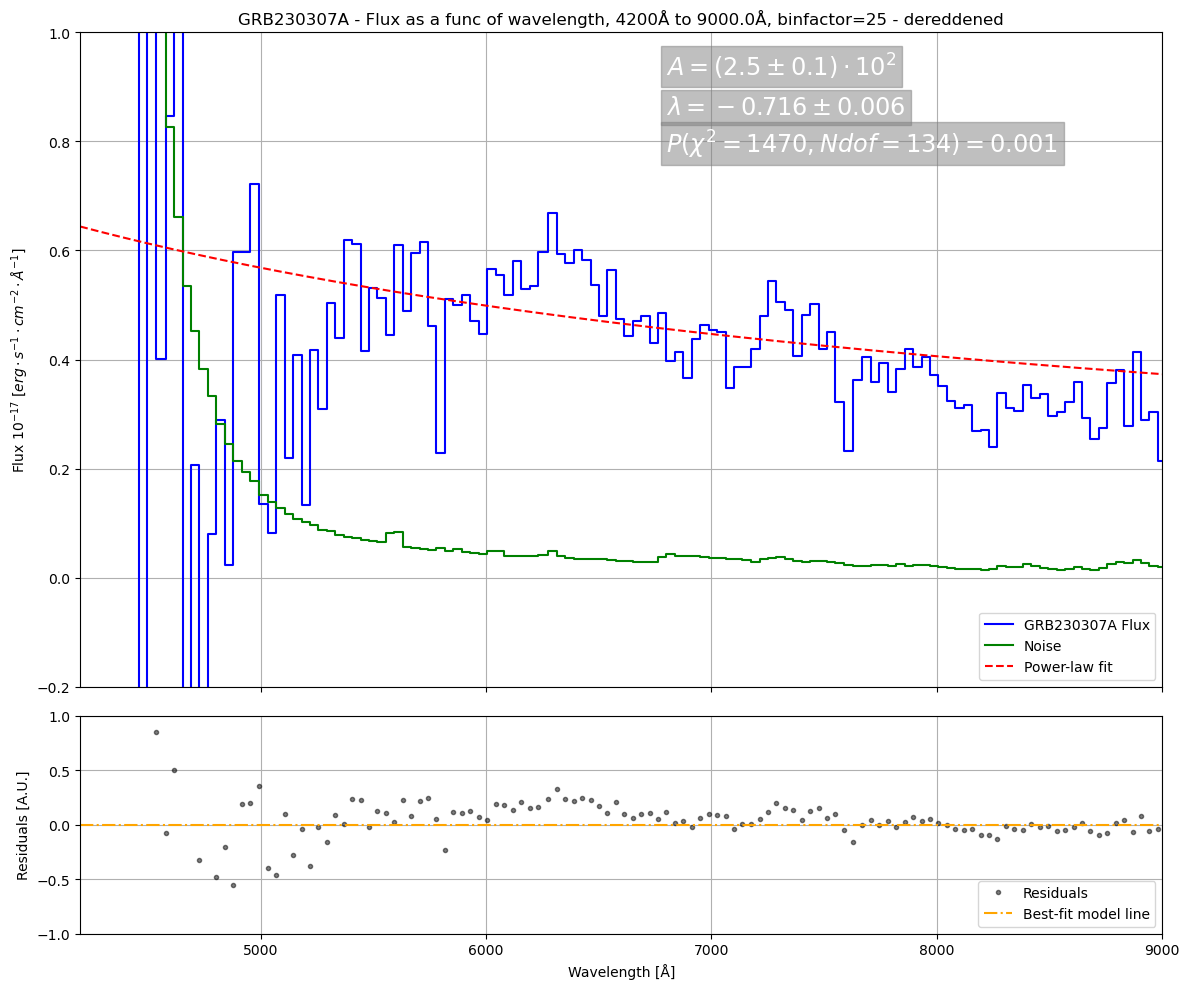

(0, [252.65526741446024, -0.7158529199305557], 1470.2746544485617)

In [23]:
Plotting_func(flux, wave, noise, binfactor=25, binning=True, save=False)

# Other Chi^2 tests (specific ranges of data, not updated/in use)

# Results for lambda<5700Å, no binning

C:\Users\Lenti\AppData\Local\Temp\ipykernel_23728\2259799551.py:22: RuntimeWarning: invalid value encountered in divide
  likelihood /= np.sum(likelihood)


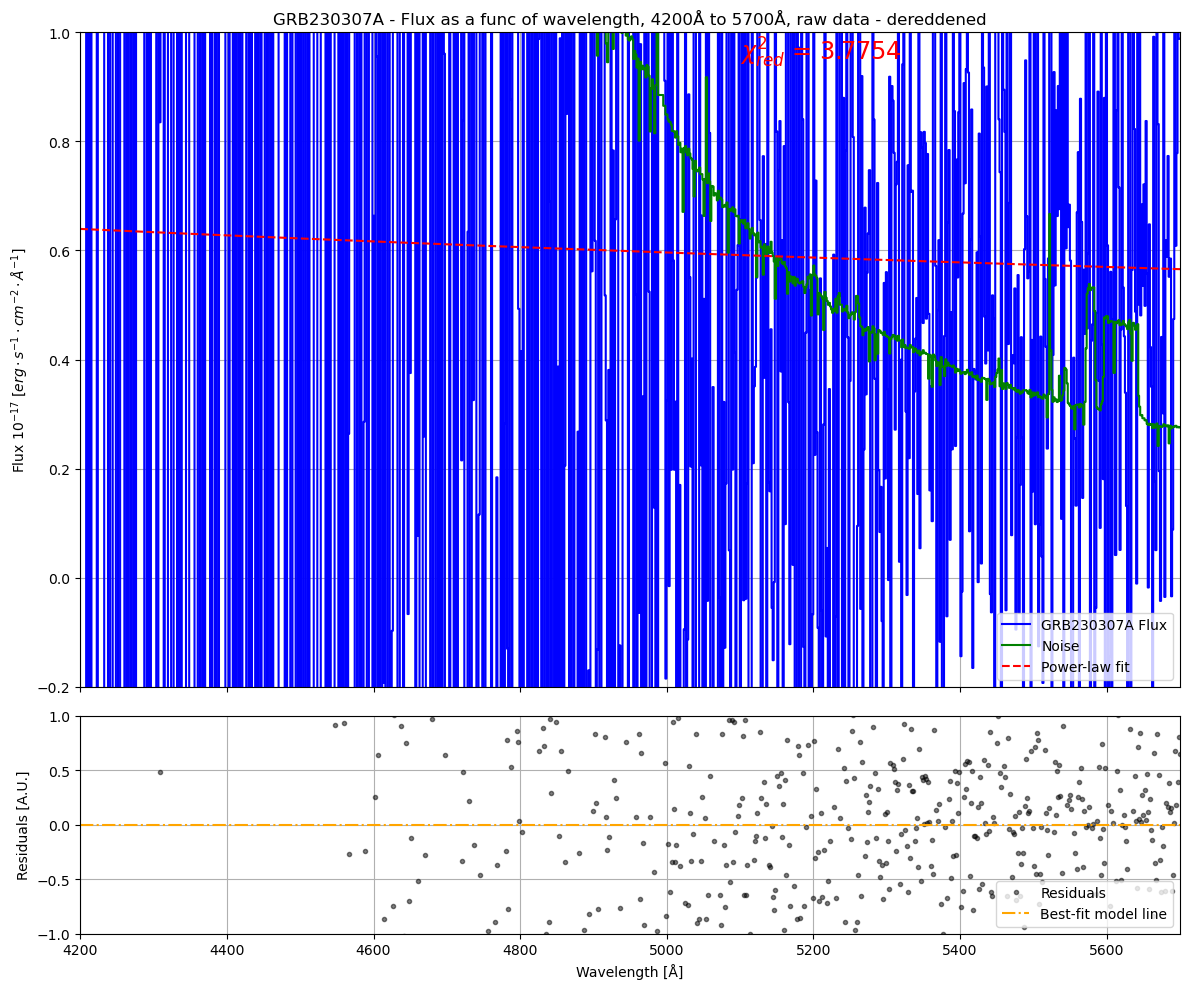

In [24]:
## Range of guess values for the chi-square function. Determined by trial and error!
a_guess_values = np.linspace(-100, 100, 500)
k_guess_values = np.linspace(-0.6, -0.4, 500)


chi2_surface, par, Chisq = Plotting_func(flux[:1059], wave[:1059], noise[:1059], a_guess_values, k_guess_values, save=True, cutoff_max=5700, chi_sq_method=True)

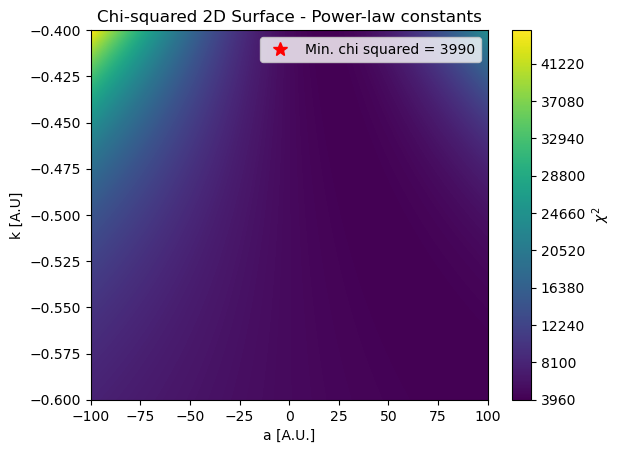

In [25]:
plt.contourf(a_guess_values, k_guess_values, chi2_surface, levels=700, cmap='viridis')
plt.xlabel("a [A.U.]")
plt.ylabel("k [A.U]")
plt.title("Chi-squared 2D Surface - Power-law constants")
cbar = plt.colorbar()
cbar.set_label('$\chi^2$')

plt.plot(par[0],par[1], 'r*', ms=10, label="Min. chi squared = {}".format(int(np.min(chi2_surface))))
plt.legend()
#plt.savefig("Chi-squared-2D-surface.png", dpi=200)

# Results for lambda<5700Å, binfactor = 2

C:\Users\Lenti\AppData\Local\Temp\ipykernel_23728\2259799551.py:22: RuntimeWarning: invalid value encountered in divide
  likelihood /= np.sum(likelihood)


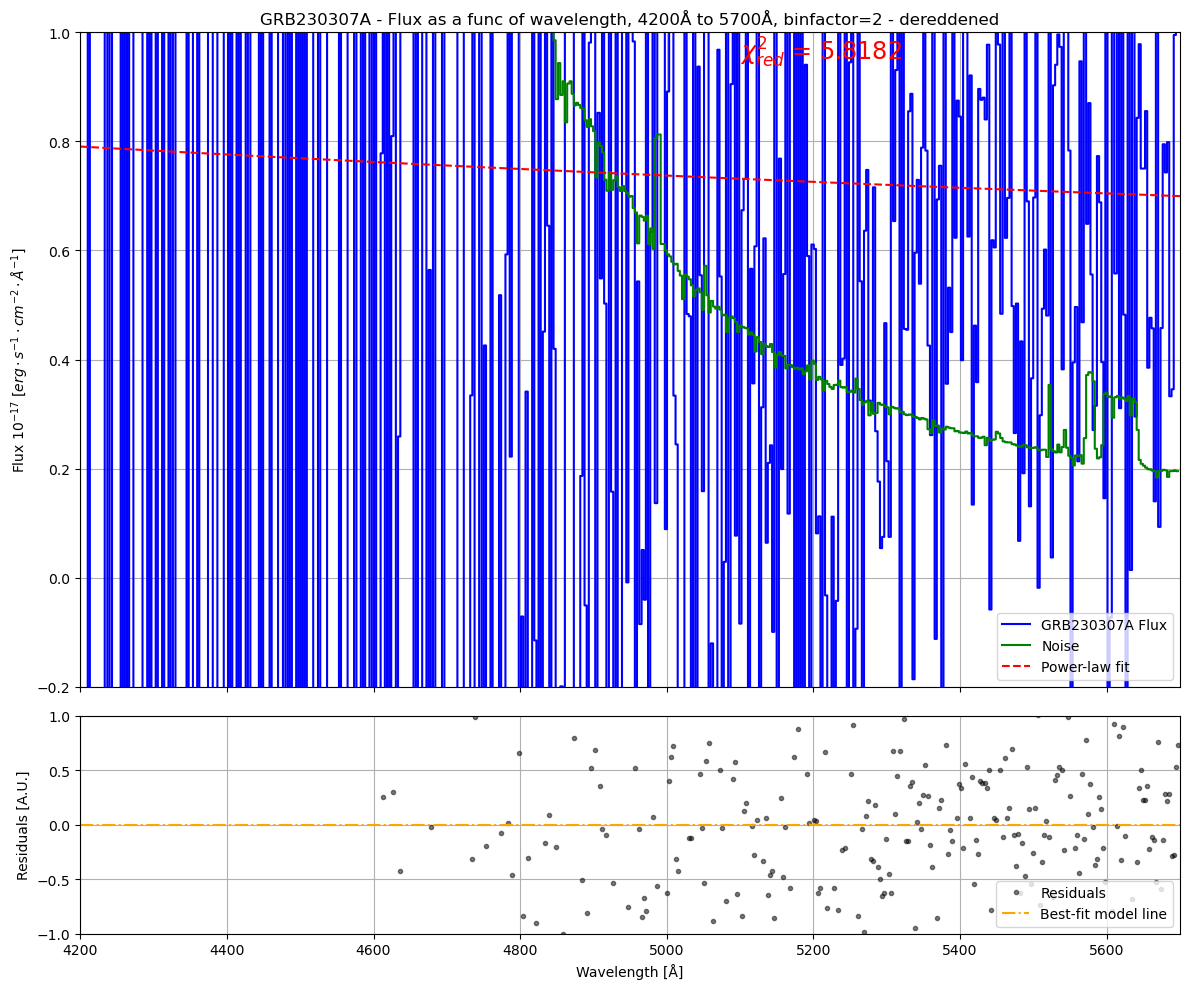

In [26]:
chi2_surface, par, Chisq = Plotting_func(flux[:1059], wave[:1059], noise[:1059], a_guess_values, k_guess_values, cutoff_max=5700, chi_sq_method=True, save=True, binning=True, binfactor=2)

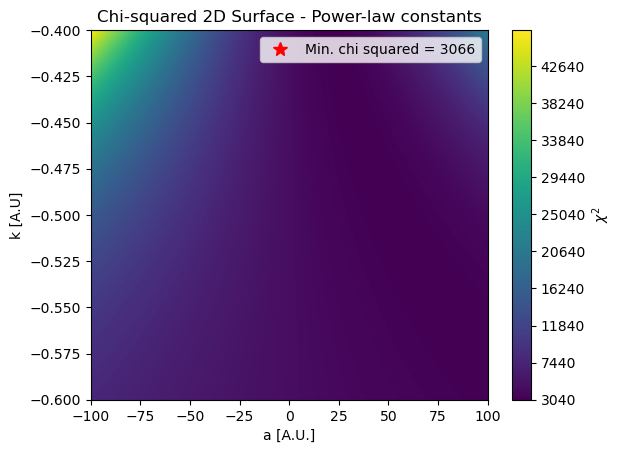

In [27]:
plt.contourf(a_guess_values, k_guess_values, chi2_surface, levels=700, cmap='viridis')
plt.xlabel("a [A.U.]")
plt.ylabel("k [A.U]")
plt.title("Chi-squared 2D Surface - Power-law constants")
cbar = plt.colorbar()
cbar.set_label('$\chi^2$')

plt.plot(par[0],par[1], 'r*', ms=10, label="Min. chi squared = {}".format(int(np.min(chi2_surface))))
plt.legend()
#plt.savefig("Chi-squared-2D-surface.png", dpi=200)

# Results for lambda<5700Å, binfactor=3

C:\Users\Lenti\AppData\Local\Temp\ipykernel_23728\2259799551.py:22: RuntimeWarning: invalid value encountered in divide
  likelihood /= np.sum(likelihood)


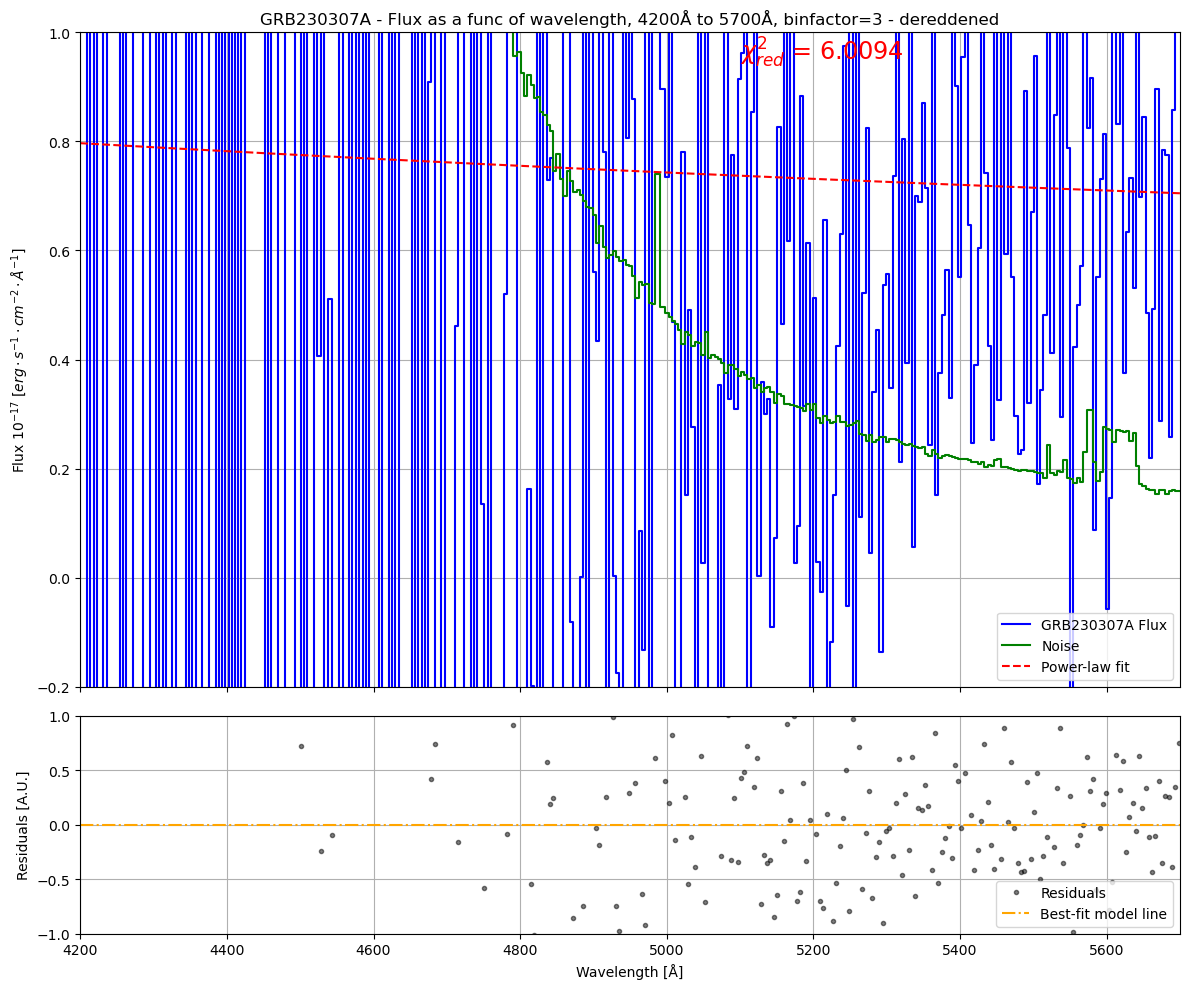

In [28]:
chi2_surface, par, Chisq = Plotting_func(flux[:1059], wave[:1059], noise[:1059], a_guess_values, k_guess_values, cutoff_max=5700, chi_sq_method=True, save=True, binning=True, binfactor=3)

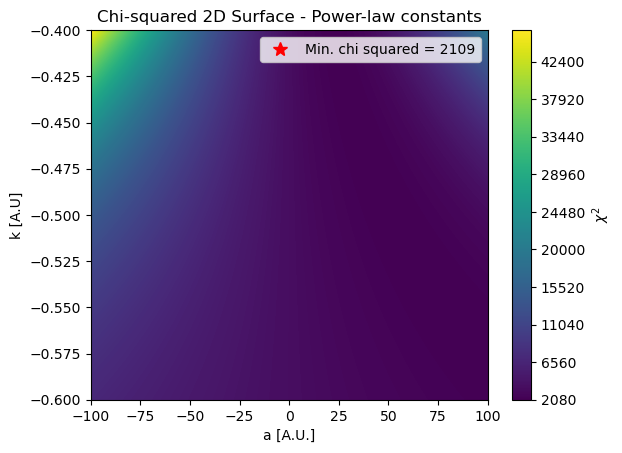

In [29]:
plt.contourf(a_guess_values, k_guess_values, chi2_surface, levels=700, cmap='viridis')
plt.xlabel("a [A.U.]")
plt.ylabel("k [A.U]")
plt.title("Chi-squared 2D Surface - Power-law constants")
cbar = plt.colorbar()
cbar.set_label('$\chi^2$')

plt.plot(par[0],par[1], 'r*', ms=10, label="Min. chi squared = {}".format(int(np.min(chi2_surface))))
plt.legend()
#plt.savefig("Chi-squared-2D-surface.png", dpi=200)

# Results for lambda<5700Å, binfactor=4

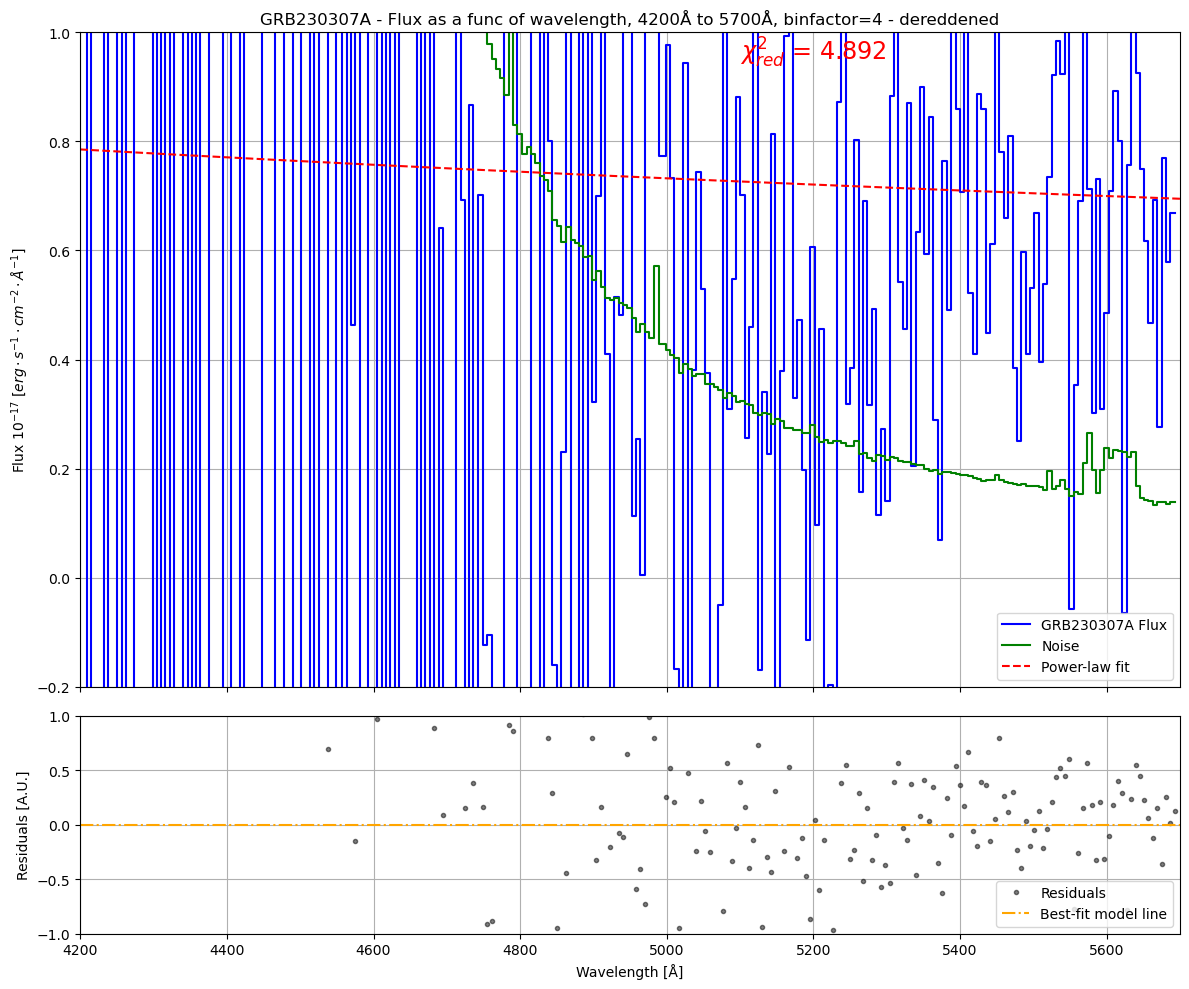

In [30]:
chi2_surface, par, Chisq = Plotting_func(flux[:1059], wave[:1059], noise[:1059], a_guess_values, k_guess_values, cutoff_max=5700, chi_sq_method=True, save=False, binning=True, binfactor=4)

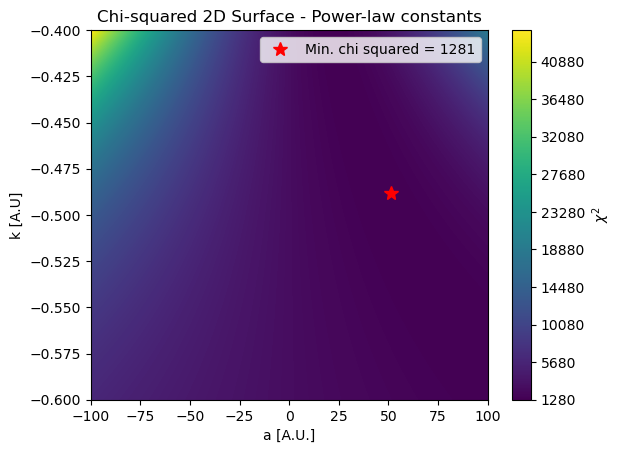

In [31]:
plt.contourf(a_guess_values, k_guess_values, chi2_surface, levels=700, cmap='viridis')
plt.xlabel("a [A.U.]")
plt.ylabel("k [A.U]")
plt.title("Chi-squared 2D Surface - Power-law constants")
cbar = plt.colorbar()
cbar.set_label('$\chi^2$')

plt.plot(par[0],par[1], 'r*', ms=10, label="Min. chi squared = {}".format(int(np.min(chi2_surface))))
plt.legend()
#plt.savefig("Chi-squared-2D-surface.png", dpi=200)

# Results for lambda<5700Å, binfactor=5

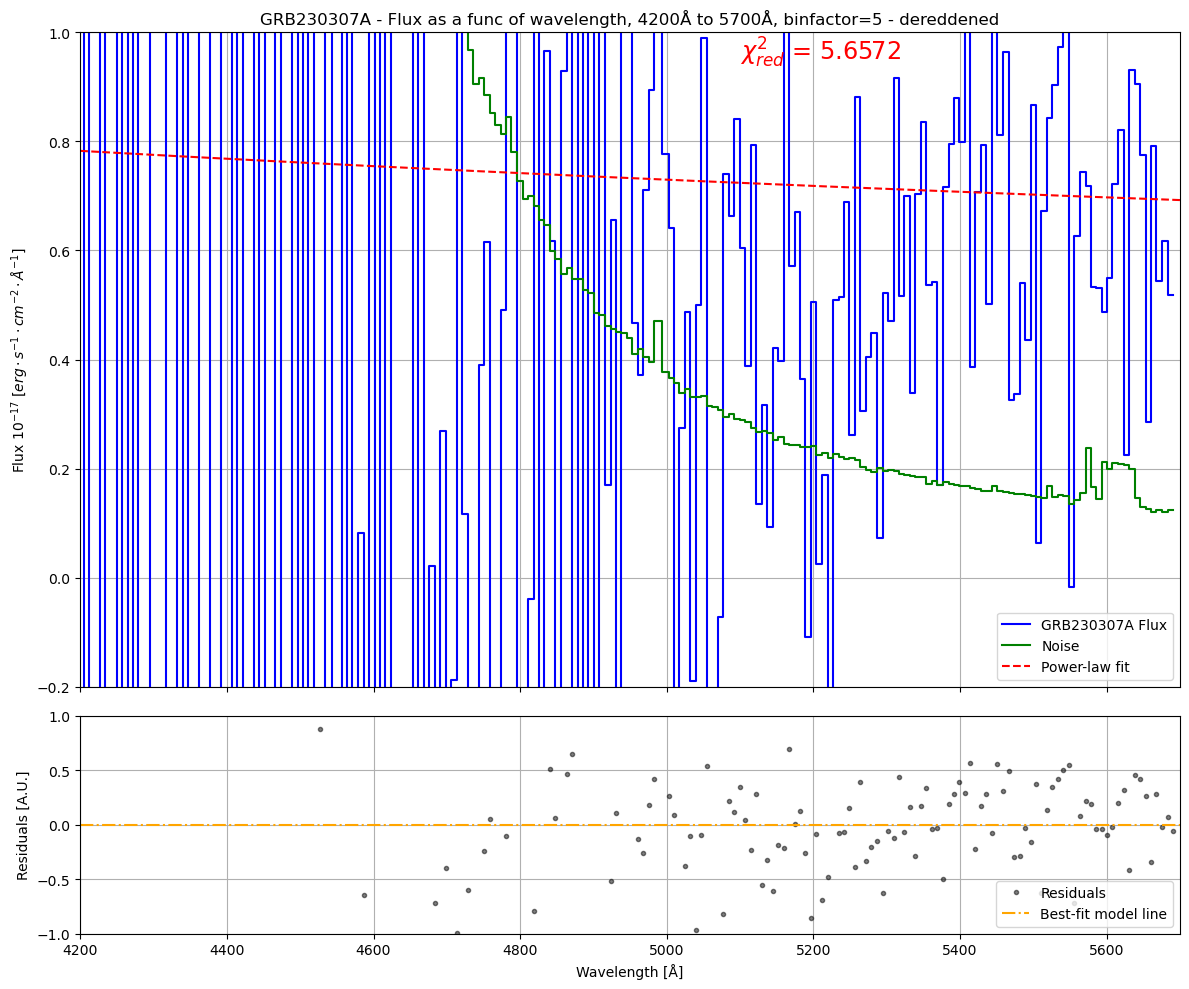

In [32]:
chi2_surface, par, Chisq = Plotting_func(flux[:1059], wave[:1059], noise[:1059], a_guess_values, k_guess_values, cutoff_max=5700, chi_sq_method=True, save=True, binning=True, binfactor=5)

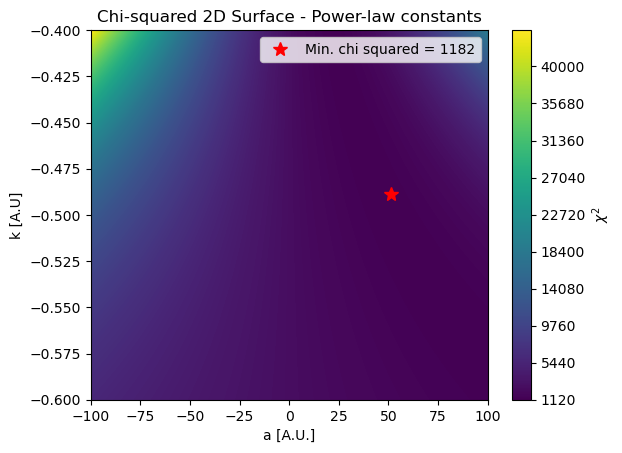

In [33]:
plt.contourf(a_guess_values, k_guess_values, chi2_surface, levels=700, cmap='viridis')
plt.xlabel("a [A.U.]")
plt.ylabel("k [A.U]")
plt.title("Chi-squared 2D Surface - Power-law constants")
cbar = plt.colorbar()
cbar.set_label('$\chi^2$')

plt.plot(par[0],par[1], 'r*', ms=10, label="Min. chi squared = {}".format(int(np.min(chi2_surface))))
plt.legend()
#plt.savefig("Chi-squared-2D-surface.png", dpi=200)

# Results for lambda<5700Å, binfactor=10

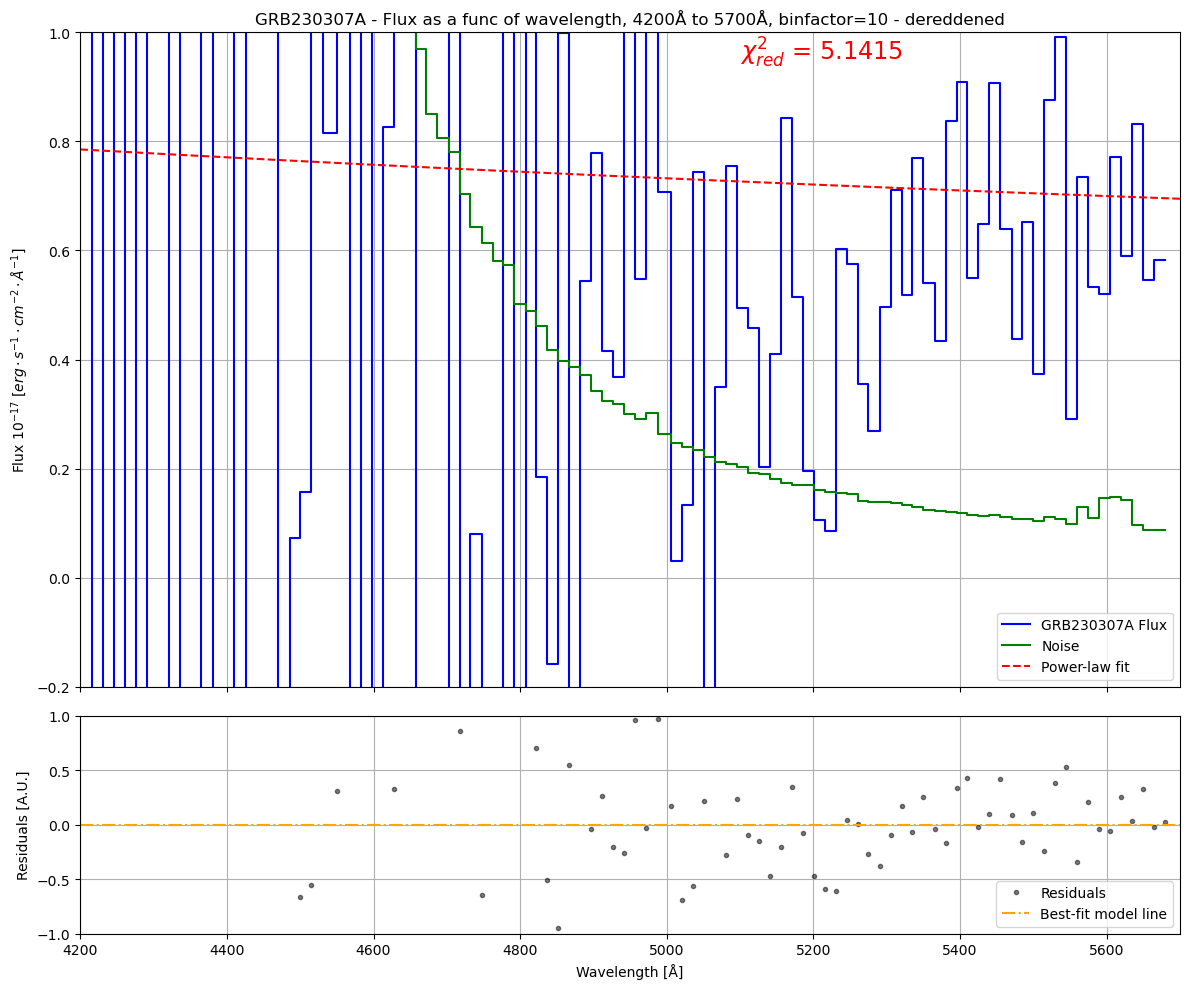

In [34]:
chi2_surface, par, Chisq = Plotting_func(flux[:1059], wave[:1059], noise[:1059], a_guess_values, k_guess_values, cutoff_max=5700, chi_sq_method=True, save=True, binning=True, binfactor=10)

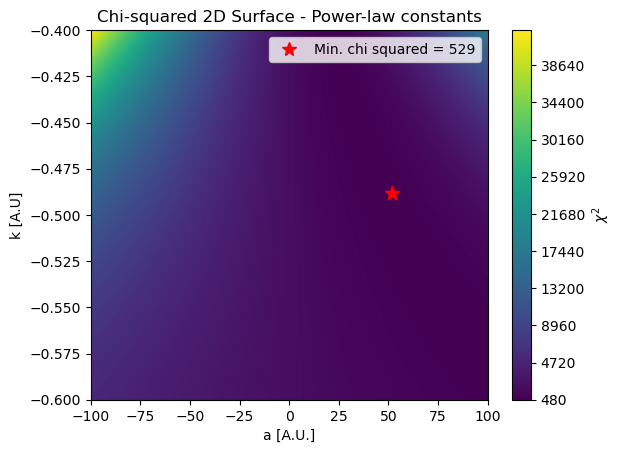

In [35]:
plt.contourf(a_guess_values, k_guess_values, chi2_surface, levels=700, cmap='viridis')
plt.xlabel("a [A.U.]")
plt.ylabel("k [A.U]")
plt.title("Chi-squared 2D Surface - Power-law constants")
cbar = plt.colorbar()
cbar.set_label('$\chi^2$')

plt.plot(par[0],par[1], 'r*', ms=10, label="Min. chi squared = {}".format(int(np.min(chi2_surface))))
plt.legend()
#plt.savefig("Chi-squared-2D-surface.png", dpi=200)

# Results for lambda<5700Å, binfactor=20

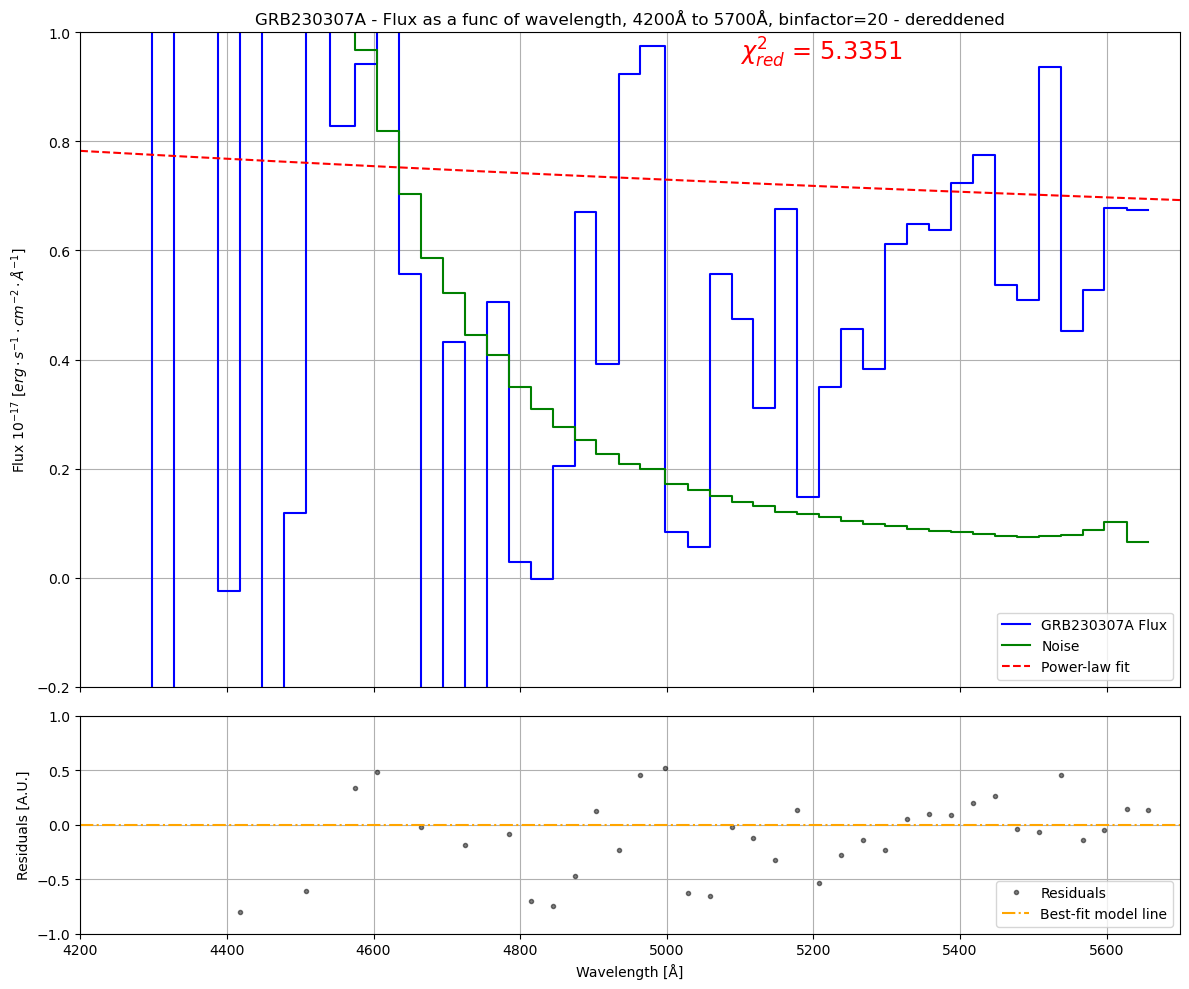

In [36]:
chi2_surface, par, Chisq = Plotting_func(flux[:1059], wave[:1059], noise[:1059], a_guess_values, k_guess_values, cutoff_max=5700, chi_sq_method=True, save=True, binning=True, binfactor=20)

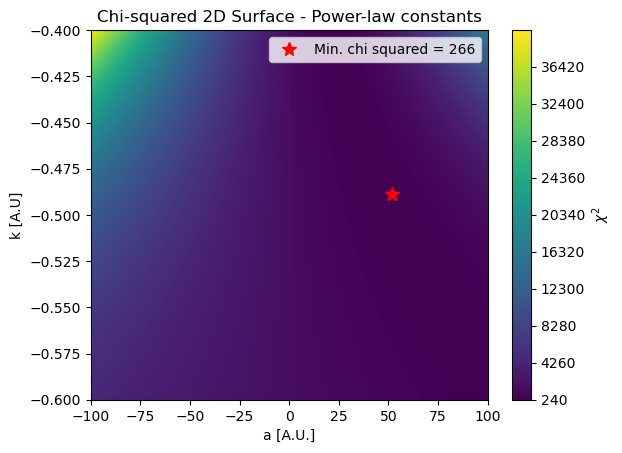

In [37]:
plt.contourf(a_guess_values, k_guess_values, chi2_surface, levels=700, cmap='viridis')
plt.xlabel("a [A.U.]")
plt.ylabel("k [A.U]")
plt.title("Chi-squared 2D Surface - Power-law constants")
cbar = plt.colorbar()
cbar.set_label('$\chi^2$')

plt.plot(par[0],par[1], 'r*', ms=10, label="Min. chi squared = {}".format(int(np.min(chi2_surface))))
plt.legend()
#plt.savefig("Chi-squared-2D-surface.png", dpi=200)

# Results for lambda<5700Å, binfactor=25

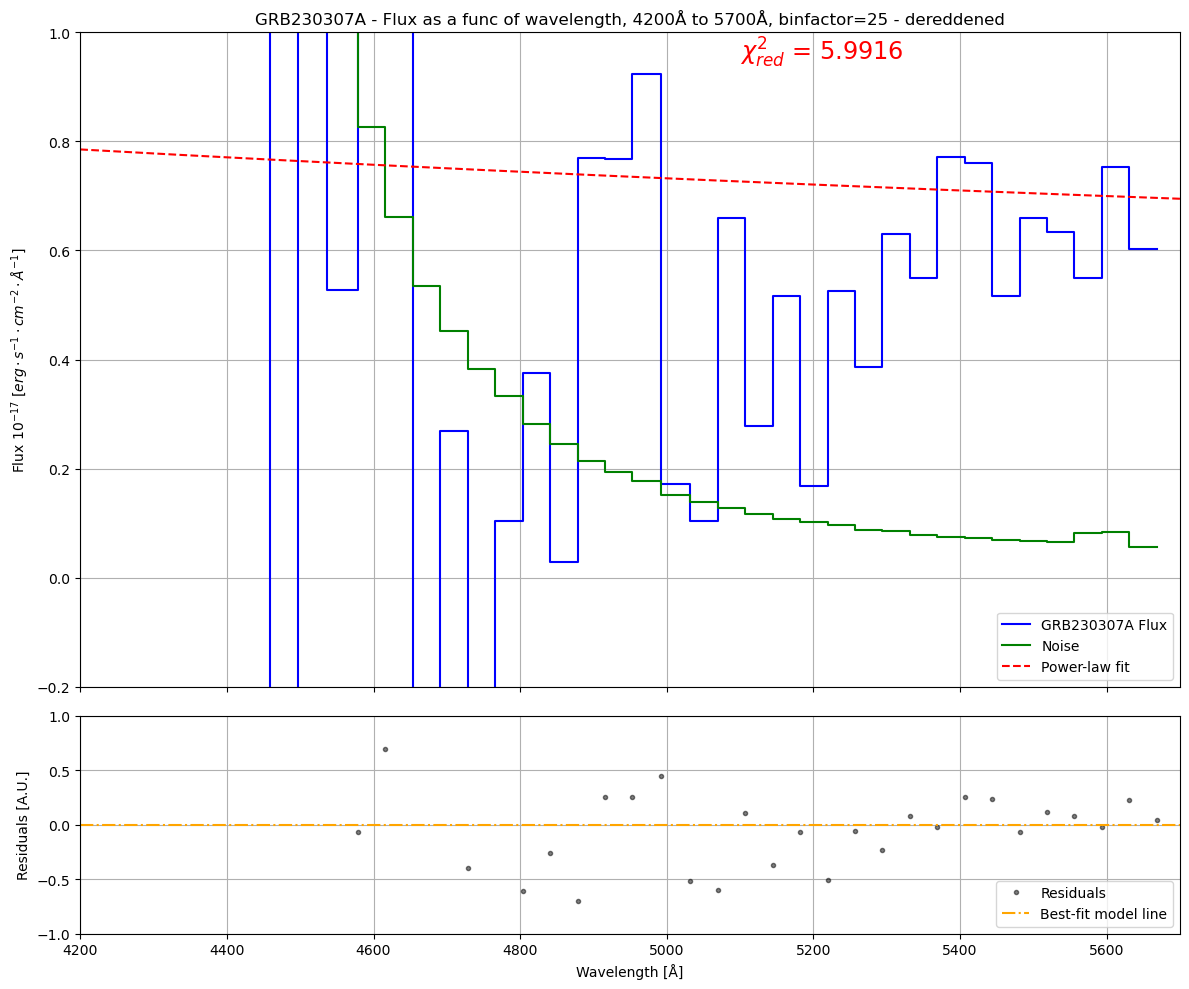

In [38]:
chi2_surface, par, Chisq = Plotting_func(flux[:1059], wave[:1059], noise[:1059], a_guess_values, k_guess_values, cutoff_max=5700, chi_sq_method=True, save=True, binning=True, binfactor=25)

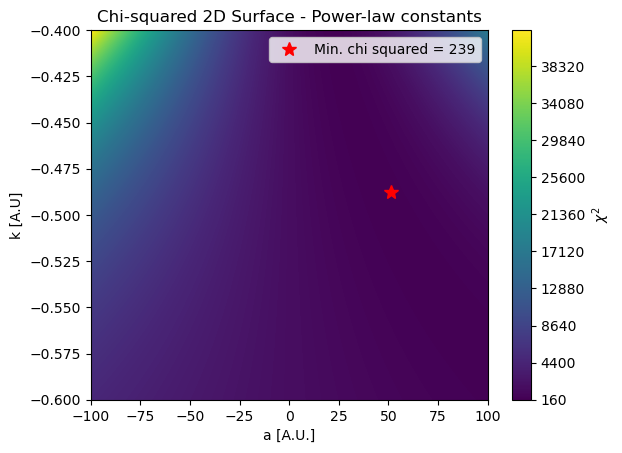

In [39]:
plt.contourf(a_guess_values, k_guess_values, chi2_surface, levels=700, cmap='viridis')
plt.xlabel("a [A.U.]")
plt.ylabel("k [A.U]")
plt.title("Chi-squared 2D Surface - Power-law constants")
cbar = plt.colorbar()
cbar.set_label('$\chi^2$')

plt.plot(par[0],par[1], 'r*', ms=10, label="Min. chi squared = {}".format(int(np.min(chi2_surface))))
plt.legend()
#plt.savefig("Chi-squared-2D-surface.png", dpi=200)